**Title**: Data Wrangling 8.2 Exercises  
**Author**: Ryan Weeks  
**Date**: 2/1/2025  
**Description**: These exercises use various Python libraries such as Pandas, Seaborn, and Matplotlib to visualize and analyze data. Strategies like filtering data with query(), calculating correlations with corr(), and creating plots such as heatmaps, box plots, and line plots are used to uncover insights in the datasets. Customizations like adding reference lines, annotations, and applying color maps are employed to enhance clarity and highlight key trends or events.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fb = pd.read_csv(r"C:\Users\Weekseey\Documents\Bellevue Work\Data Wrangling\fb_stock_prices_2018.csv", index_col='date', parse_dates=True)
eq = pd.read_csv(r"C:\Users\Weekseey\Documents\Bellevue Work\Data Wrangling\earthquakes.csv")
covid = pd.read_csv(r"C:\Users\Weekseey\Documents\Bellevue Work\Data Wrangling\covid19_cases.csv").assign(
    date=lambda x: pd.to_datetime(x.dateRep, format='%d/%m/%Y')
).set_index('date').replace(
    'United_States_of_America', 'USA'
).sort_index()['2020-01-18':'2020-09-18']

# 1.

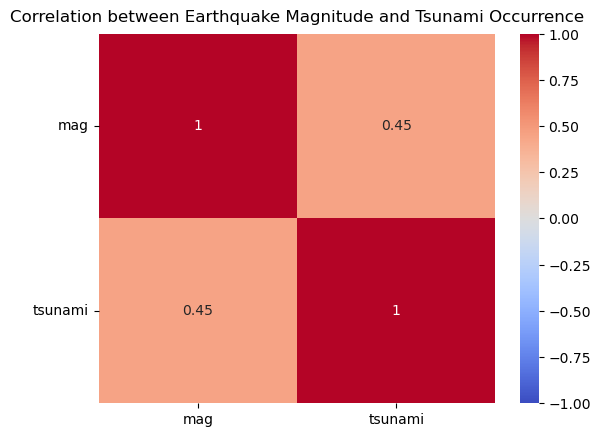

In [6]:
# Filter data for 'mb' magnitude type
filtered_data = eq.query('magType == "mb"')[['mag', 'tsunami']]

# Create a correlation heatmap
sns.heatmap(
    filtered_data.corr(), 
    annot=True, 
    center=0, 
    vmin=-1, 
    vmax=1, 
    cmap='coolwarm'
)

# Customize plot appearance
plt.yticks(rotation=0)
plt.title('Correlation between Earthquake Magnitude and Tsunami Occurrence', y=1.01)
plt.show()

# 2.

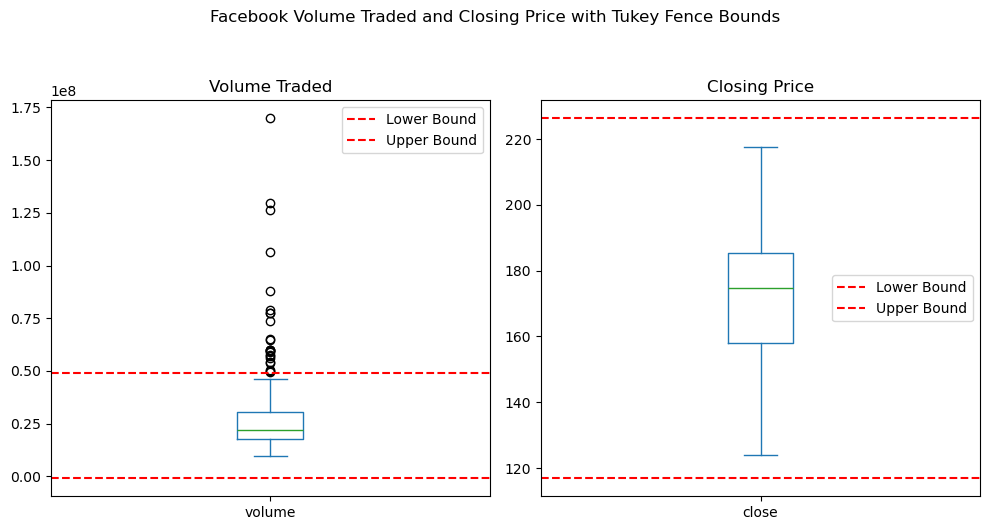

In [11]:
# Select relevant columns
data_columns = ['volume', 'close']
subset_data = fb[data_columns]

# Calculate the quantiles and IQR for each column
quantiles = subset_data.quantile([0.25, 0.75])

# Create subplots for the box plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

# Plot box plots
subset_data.plot(kind='box', subplots=True, ax=axes, title=['Volume Traded', 'Closing Price'])

# Draw Tukey Fence bounds
for ax, col in zip(axes, data_columns):
    q1 = quantiles.loc[0.25, col]
    q3 = quantiles.loc[0.75, col]
    iqr = q3 - q1  # IQR is Q3 - Q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    ax.axhline(lower_bound, color='red', linestyle='--', label='Lower Bound')
    ax.axhline(upper_bound, color='red', linestyle='--', label='Upper Bound')
    ax.legend()

# Set the title for the overall plot
plt.suptitle('Facebook Volume Traded and Closing Price with Tukey Fence Bounds', y=1.05)
plt.tight_layout()
plt.show()

# 3.

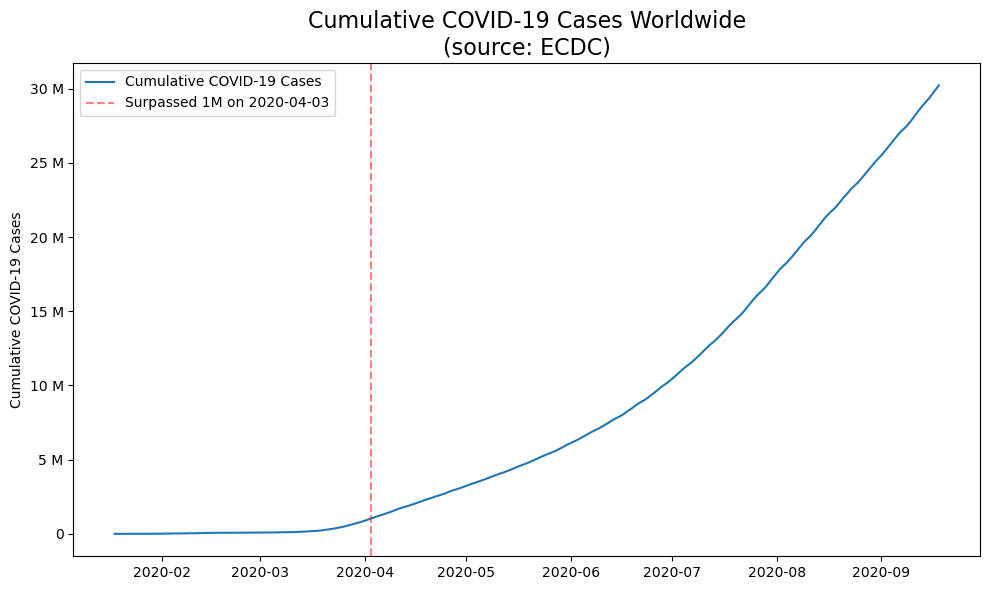

In [14]:
from matplotlib.ticker import EngFormatter

# Calculate cumulative cases (sum per day)
cumulative_cases = covid.groupby(pd.Grouper(freq='1D')).sum().cases.cumsum()

# Create the plot for cumulative cases over time
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cumulative_cases.index, cumulative_cases, label='Cumulative COVID-19 Cases')

# Set y-axis label and format y-axis with engineering notation
ax.set_ylabel('Cumulative COVID-19 Cases')
ax.yaxis.set_major_formatter(EngFormatter())

# Find the date when cumulative cases surpassed 1 million
over_1M = cumulative_cases[cumulative_cases >= 1e6].index[0]

# Add vertical line indicating when the threshold was surpassed
ax.axvline(over_1M, linestyle='--', color='red', alpha=0.5, label=f"Surpassed 1M on {over_1M.strftime('%Y-%m-%d')}")

# Title and legend
ax.set_title('Cumulative COVID-19 Cases Worldwide\n(source: ECDC)', fontsize=16)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# 4.

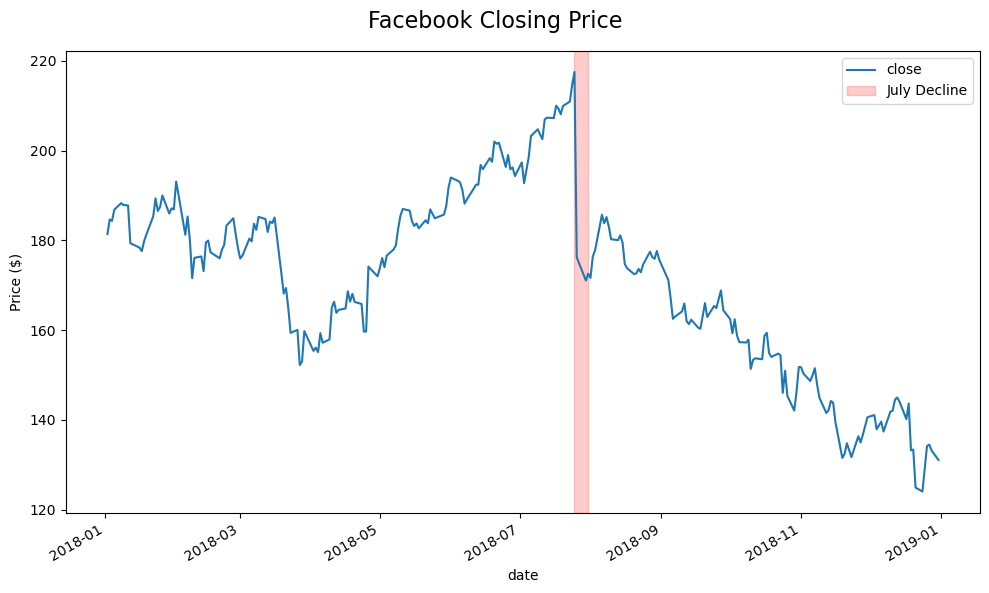

In [17]:
# Plotting the closing price of Facebook
fb.close.plot(kind='line', figsize=(10, 6))

# Add a shaded region between '2018-07-25' and '2018-07-31' to mark the decline
plt.axvspan(
    '2018-07-25', '2018-07-31', alpha=0.2, color='red', label='July Decline'
)

# Adding labels and title
plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price', fontsize=16)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# 5.

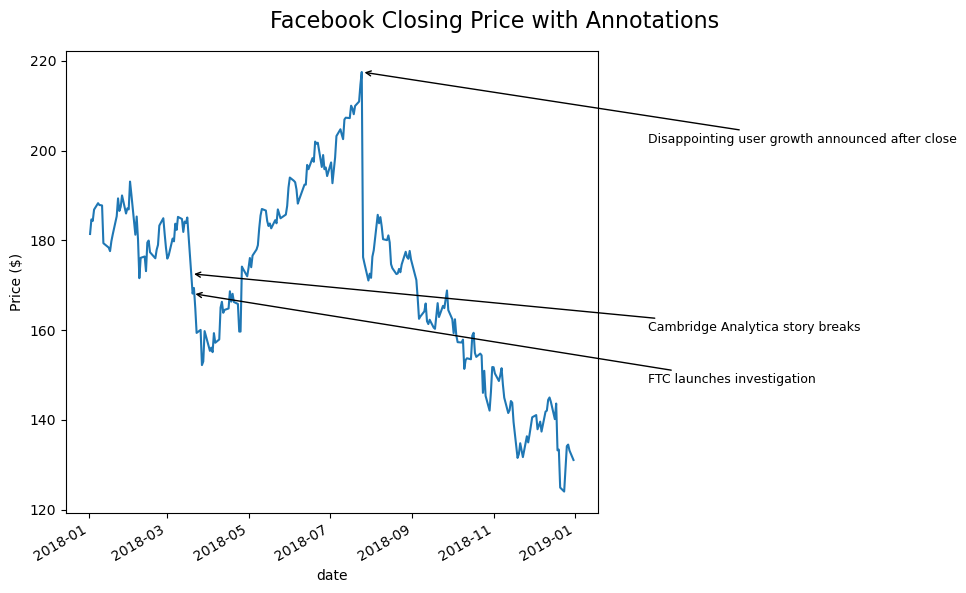

In [20]:
# Plotting the Facebook closing price
fb.close.plot(kind='line', figsize=(10, 6))

# List of events and their corresponding dates
notes = [
    ('Disappointing user growth announced after close', '2018-07-25'),
    ('Cambridge Analytica story breaks', '2018-03-19'),
    ('FTC launches investigation', '2018-03-20')
]

# For repeatable random jitter
np.random.seed(1)

# Annotating the events
for text, date in notes:
    y_value = fb.close[date]
    jitter = np.random.uniform(-20, -10, 1)  # Adding vertical jitter to the annotation
    plt.annotate(
        text,
        xy=(date, y_value),
        xytext=(pd.to_datetime('2019-02-25'), y_value + jitter),  # Adjusting the annotation's offset
        arrowprops=dict(arrowstyle='->', color='black'),
        fontsize=9
    )

# Adding labels and title
plt.ylabel('Price ($)')
plt.suptitle('Facebook Closing Price with Annotations', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()

# 6.

[<Axes: xlabel='close', ylabel='volume'>,
 <Axes: xlabel='close', ylabel='residuals'>,
 <Axes: xlabel='volume', ylabel='close'>,
 <Axes: xlabel='volume', ylabel='residuals'>]

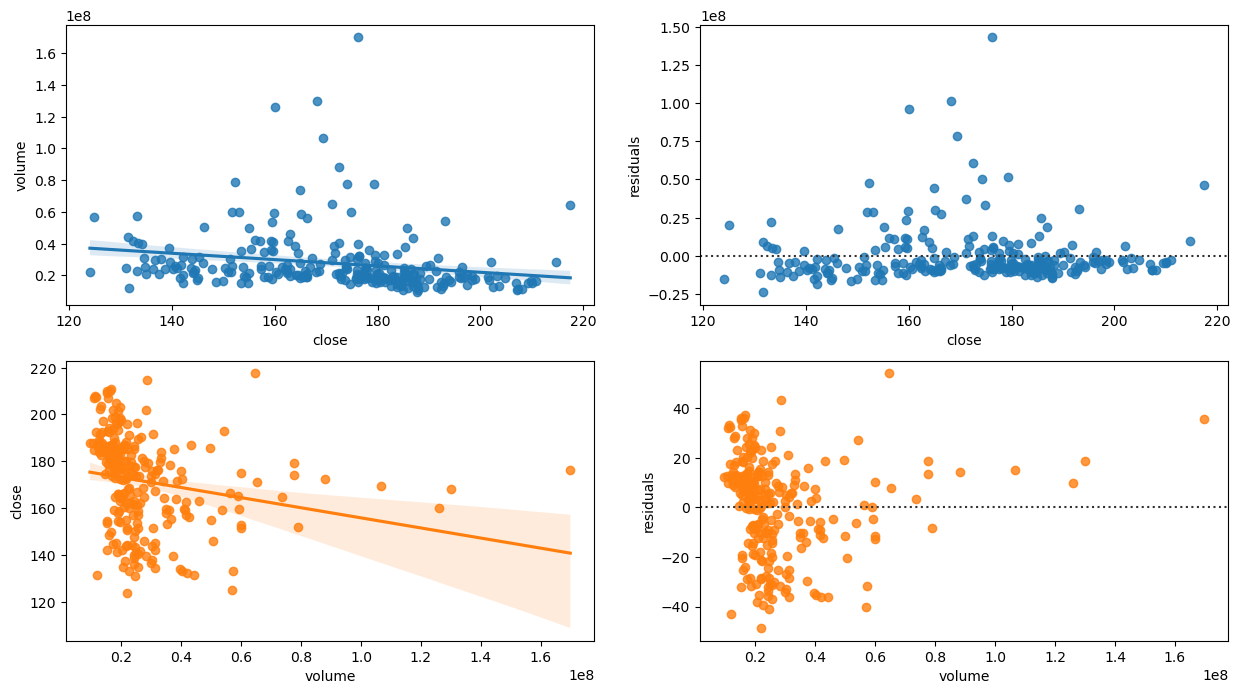

In [29]:
import itertools

def reg_resid_plots(data):

"""
    This function creates regression and residual plots for every pair of columns
    in the input data, showing them side-by-side using `seaborn`. It's a great way 
    to explore relationships between variables and visualize residuals in one go.

    Parameters:
        - data: A `pandas.DataFrame` containing the columns to be plotted

    Returns:
        A list of `Axes` objects for each plot generated.
"""

    num_cols = data.shape[1]
    permutation_count = num_cols * (num_cols - 1)

    fig, ax = plt.subplots(
        permutation_count, 
        2, 
        figsize=(15, 4 * permutation_count)
    )

    # Accessing colormap with plt.get_cmap() for backward compatibility
    colormap = plt.get_cmap('tab10')

    for (x, y), axes, color in zip(
        itertools.permutations(data.columns, 2), 
        ax,
        [colormap(i) for i in range(len(ax))]
    ):
        for subplot, func in zip(axes, (sns.regplot, sns.residplot)):
            func(x=x, y=y, data=data, ax=subplot, color=color)
            
            if func == sns.residplot:
                # mark the residuals as such
                subplot.set_ylabel('residuals')

    return fig.axes

# Example usage
reg_resid_plots(fb[['close', 'volume']])